### Revised TRAPPIST-1 Evolution Simulation

#### Imports and Units

In [ ]:
import re
import rebound
import reboundx
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
from time import time
from astropy import constants as const
from astropy import units as u
import warnings
warnings.filterwarnings('ignore')

# Unit conversions
AU = u.AU.to(u.cm)    
Msun = u.Msun.to(u.g) 
yr = u.yr.to(u.s)    
r_earth = u.earthRad.to(u.AU)
m_earth = u.Mearth.to(u.Msun)
r_sun = u.Rsun.to(u.AU) 

#### Randomly generate mass, radius, & semimajor axis values
Planetary parameters taken from the NASA Exoplanet Archive, based on Agol 2021.

In [353]:
def parse_entry(entry):
    """
    Parses strings of form:
        '1.0±0.01'
        '1.04 +0.01 -0.02'
    
    Returns:
        mu (float), sigma (float)
    """
    
    if pd.isna(entry):
        raise ValueError("Entry is NaN")
    
    # Remove extra whitespace
    entry = entry.strip()
    
    # Remove spaces for easier parsing
    entry_nospace = entry.replace(" ", "")
    
    # Case 1: symmetric uncertainty (±)
    match_pm = re.match(r"^([0-9.+\-eE]+)±([0-9.+\-eE]+)$", entry_nospace)
    if match_pm:
        mu = float(match_pm.group(1))
        sigma = float(match_pm.group(2))
        return mu, sigma
    
    # Case 2: asymmetric uncertainty (+x -y)
    match_asym = re.match(
        r"^([0-9.+\-eE]+)\+([0-9.+\-eE]+)\-([0-9.+\-eE]+)$",
        entry_nospace
    )
    if match_asym:
        mu = float(match_asym.group(1))
        sigma_plus = float(match_asym.group(2))
        sigma_minus = float(match_asym.group(3))
        
        # Convert asymmetric → effective symmetric σ
        sigma = 0.5 * (sigma_plus + sigma_minus)
        
        return mu, sigma
    
    raise ValueError(f"Could not parse entry: {entry}")

def generate_params(csv_file, params, n_samples=1):
    """
    Reads planet parameter CSV and returns Monte Carlo samples
    for mass, radius, and semimajor axis.
    """
    
    df = pd.read_csv(csv_file)
    
    # Set index to Source column for easy lookup
    df = df.set_index("Source")
    
    # Extract Agol et al. 2021 column
    col = "Agol et al. 2021"
    
    params_dict = {}
    
    for param in params:
        # Parse parameter
        mu, sigma = parse_entry(df.loc[param, col])
    
        # Draw Gaussian samples
        samples  = np.random.normal(mu,  sigma,  n_samples)

        # Add to dict
        params_dict[param] = samples
    
    return params_dict

planet_names = ['b', 'c', 'd']
# Nested dict containing params for each planet in sim
planet_params = {f"{planet_name}": generate_params(f'TRAPPIST-1_params/TRAPPIST-1_{planet_name}_planet_params.csv', ('a (au)', 'Rp (R⨁)', 'Mp (M⨁)')) for planet_name in planet_names}
stellar_params = generate_params('TRAPPIST-1_params/TRAPPIST-1_stellar_params.csv', ('R✶ (R⦿)', 'M✶ (M⦿)'))

#### Sim Setup

In [354]:
# Create the simulation
sim = rebound.Simulation()
sim.units = ('AU', 'yr', 'Msun')
sim.integrator = "whfast"
sim.random_seed = 13741154 # for reproducibility

# Add the star
m_star = stellar_params['M✶ (M⦿)']
r_star = stellar_params['R✶ (R⦿)'] * r_sun
sim.add(m=m_star, r=r_star)

num_planets = len(planet_names)

# Define planet masses (m)
m_vals = np.array([planet_params[planet_name]['Mp (M⨁)'] for planet_name in planet_names])
m_vals *= m_earth # convert to Msun

# Define planet radii (r)
r_vals = np.array([planet_params[planet_name]['Rp (R⨁)'] for planet_name in planet_names])
r_vals *= r_earth # convert to AU

# Define initial eccentricities (e)
e_vals = np.zeros_like(m_vals)

# Draw initial mean anomalies (M)
M_vals = np.random.uniform(0, 2*np.pi, size=num_planets)

# Initial semimajor axis of b
a_b = 0.1 

# Draw initial ratios from log normal
initial_P_ratios = np.random.lognormal(0.703, 0.1, size=num_planets-1) 
                                            # In Keller, 0.313
print("Initial period ratios:")
print(initial_P_ratios)

# Define initial periods (P) and semimajor axes (a)
P_b = a_b**(3/2)
P_c = P_b * 3/2 * initial_P_ratios[0]
P_d = P_c * 3/2 * initial_P_ratios[1]
P_vals = np.array([P_b, P_c, P_d])
a_vals = P_vals**(2/3)

print("Initial semimajor axis values:")
print(a_vals)

# Add planets 
for i in range(num_planets):
    sim.add(m=m_vals[i], r=r_vals[i], a=a_vals[i], e=e_vals[i], M=M_vals[i])

# Move to center of momentum
sim.move_to_com()
ps = sim.particles
planets = ps[1:] # for easier indexing

Initial period ratios:
[1.72769023 1.90057522]
Initial semimajor axis values:
[0.1        0.18867083 0.37933447]


#### Sim Params
Based on section 2.1 in Keller et al. (2026).

In [355]:
def get_taus(a_vals, m_vals, M_star, h, Sigma, alpha=1.5):
    '''
    Computes damping timescales based on current semimajor axis values.
    
    Parameters:
        a_vals: 1D NumPy array of current semimajor axis values.
    
    Returns:
        tau_a: semimajor axis damping timescale.
        tau_e: eccentricity damping timescale.
    '''
    tau_a = (1/(2.7+1.1*alpha)) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**2 / np.sqrt(const.G.value*M_star/a_vals**3))
    tau_e = (1/0.780) * (M_star/m_vals) * (M_star/(Sigma*a_vals**2)) * (h**4 / np.sqrt(const.G.value*M_star/a_vals**3))
    return tau_a, tau_e

def get_Sigma(a_vals, Sigma_1au, alpha=1.5):
    return Sigma_1au * a_vals**(-alpha)

def get_h(K, alpha=1.5):
    return np.sqrt(0.780/(2.7+1.1*alpha)/K)

def get_Sigma(Sigma_1au, a_vals, alpha=1.5):
    return Sigma_1au * (a_vals**-alpha)

# Draw surface density at 1au from log uniform
Sigma_1au = scipy.stats.loguniform.rvs(a=10, b=10000, size=1) # in g/cm^2
Sigma_1au *= AU**2 / Msun # unit conversion for sim
print(f"Sigma_1au: {float(Sigma_1au):.3e}")

# Draw K-factor from log uniform and solve for h
K = scipy.stats.loguniform.rvs(a=10, b=1000, size=1)
h = get_h(K) # here, h = h_1au since there is no flaring
print(f"h_1au: {float(h):.4g}")
print(f"tau_a of b: {float(get_taus(a_b, m_vals, m_star, h, get_Sigma(Sigma_1au, a_b))[0][0]):.3e}")

Sigma_1au: 1.744e-04
h_1au: 0.048
tau_a of b: 2.131e+08


#### Handling Close Encounters
Symplectic integrators are not designed to handle close encounters, so we discard sims where planets ventured within five mutual Hill radii of each other.

In [356]:
def get_hill_radius(m1, a1, m2, a2, M_star):
    return ((m1+m2)/(3*M_star))**1/3 * (a1+a2)/2

#### Implementing REBOUNDx forces
There are several options for the location and width of the inner disk edge (IDE).
- Keller et al. (2026) used 0.05 as the position and 0.01 as the width.
- Huang & Ormel (2022) used positions $r_c \in [0.013 - 0.030 \text{ au}]$ with width $\Delta = 2hr_c = 0.06r_c$. In particular, $r_c = 0.023$ and $\Delta = 0.00138$ worked best.

In [357]:
rebx = reboundx.Extras(sim)
mig = rebx.load_force("type_I_migration")
rebx.add_force(mig)

mig.params["tIm_scale_height_1"] = h # = h_1au
mig.params["tIm_surface_density_1"] = Sigma_1au
mig.params["tIm_surface_density_exponent"] = 1.5 # alpha
mig.params["tIm_flaring_index"] = 0 # beta

mig.params["ide_position"] = 0.023 # inner disk edge
mig.params["ide_width"] = 0.00138

#### Data storage

In [358]:
sim.dt = planets[0].P / 20 # 1/20 of planet b

def data_df(n_out, times):        
    return pd.DataFrame({
        "time": times,
        "a": np.zeros(n_out),
        "e": np.zeros(n_out),
        "P": np.zeros(n_out),
        "P_ratio": np.zeros(n_out),
        "tau_a": np.zeros(n_out),
        "tau_e": np.zeros(n_out)
    })

# Set up times for integration & data collection
stage1_end = 100000 # yrs
n_out = 1000 # number of data points to collect

stage1_times = np.linspace(0, stage1_end, n_out)  # all times to integrate over
stage1_data = {name : data_df(n_out, stage1_times) for name in planet_names[:num_planets]}

#### It's time to integrate

In [359]:
tstart = time()
stop_sim = False

for i, t in enumerate(stage1_times):  
    sim.integrate(t)
    
    current_a_vals = np.array([p.a for p in sim.particles[1:]])
    
    for p in range(num_planets):
        name = planet_names[p]
        stage1_data[name]["a"][i] = planets[p].a
        stage1_data[name]["e"][i] = planets[p].e
        # stage1_data[name]["P"][i] = planets[p].P
        # stage1_data[name]["tau_a"][i] = tau_a[p]
        # stage1_data[name]["tau_e"][i] = tau_e[p]
        if p != num_planets-1: # don't record period ratio for last planet
            stage1_data[name]["P_ratio"][i] = planets[p+1].P / planets[p].P
            
            # Stop sim if within 5*r_hill
            r_hill = get_hill_radius(m_vals[p], current_a_vals[p], m_vals[p+1], current_a_vals[p+1], m_star)
            d = np.linalg.norm([planets[p].x - planets[p+1].x, planets[p].y - planets[p+1].y, planets[p].z - planets[p+1].z])
            if d < 5*r_hill:
                stop_sim = True
                print("Close encounter")
            
        # Stop sim if planet goes into star
        if planets[p].a < 0.001:
            stop_sim = True
            print("Planet collided with star")
    
    if stop_sim:
        print(f"Stopped integration at t={t}")
        break
        
print(f'finished integration in {time()-tstart:.4} sec')

finished integration in 15.56 sec


#### Plot it!

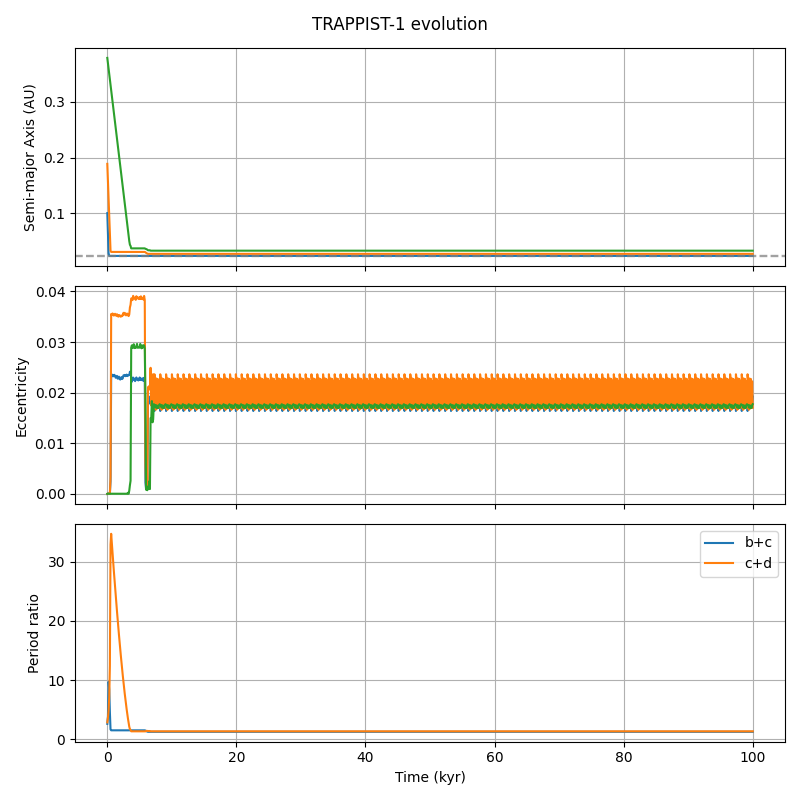

In [360]:
%matplotlib widget

def plot_trappist1():
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)
    fig.set_figwidth(8)
    fig.set_figheight(8)

    for p in range(num_planets):
        # could also try plotting log
        name = planet_names[p]
        ax1.plot(stage1_times/1000, stage1_data[name]["a"], label=name)
        ax2.plot(stage1_times/1000, stage1_data[name]["e"], label=name)
        if p != num_planets-1:
            ax3.plot(stage1_times/1000, stage1_data[name]["P_ratio"], label=f"{name}+{planet_names[p+1]}")
        # ax4.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        # ax5.plot(stage1_times/1000, stage1_data[name]["tau_a"], label=name)
        
    plt.xlabel("Time (kyr)")
    ax1.set_ylabel("Semi-major Axis (AU)")
    ax2.set_ylabel("Eccentricity")
    ax3.set_ylabel("Period ratio")
    # ax4.set_ylabel("tau_a")
    # ax5.set_ylabel("tau_e")
    
    # ax1.set_ylim(0,0.45)
    # ax2.set_ylim(-0.1,0.45)
    # ax3.set_ylim(0,2.1)
    # ax4.set_ylim(-10000, 0)s
    # ax5.set_ylim(-10000, 0)
    
    # Plot ide location & width
    ax1.axhline(mig.params["ide_position"], color='gray', ls='--', alpha=0.7)
    ax1.axhline(mig.params["ide_position"] - mig.params["ide_width"], color='gray', ls='--', alpha=0.1)
    ax1.axhline(mig.params["ide_position"] + mig.params["ide_width"], color='gray', ls='--', alpha=0.1)

    fig.subplots_adjust(hspace=0)

    plt.suptitle("TRAPPIST-1 evolution")
    ax1.grid(True); ax2.grid(True); ax3.grid(True); # ax4.grid(True)
    plt.legend(); plt.tight_layout(); plt.show()

plot_trappist1()